In [ ]:
"""
Author: Weimin Wang 
Date: March, 2017

Part of the idea of this tutorial was from the blog: 

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

This tutorial uses data that can be downloaded from:

https://www.kaggle.com/c/dogs-vs-cats/data

"""

In [1]:
import os
import h5py
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import Model
from keras.applications.vgg16 import VGG16
import scipy.misc
import pandas as pd 
import keras.backend as K
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

Using Theano backend.


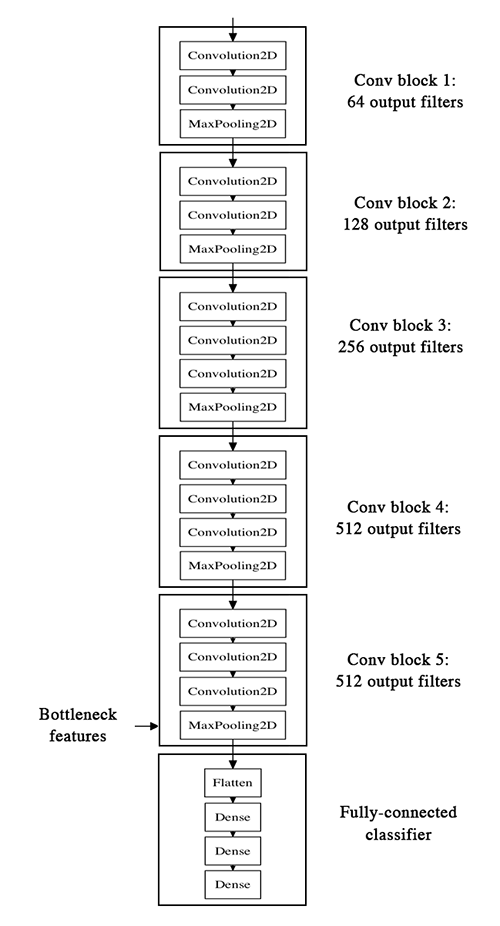

In [5]:
from IPython.display import Image
Image('C:/Users/WAWEIMIN/Google Drive/CatsAndDogs/files/vgg16_original.png')

## Layer names for each block of VGG16


In [ ]:
"""
https://github.com/fchollet/keras/blob/master/keras/applications/vgg16.py

input image -> img_input 

# Block 1
x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv1')(x)
x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv2')(x)
x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv1')(x)
x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv2')(x)
x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv1')(x)
x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv2')(x)
x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x) 

# Classification block
x = Flatten(name='flatten')(x)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(classes, activation='softmax', name='predictions')(x)

"""

## When and how to fine-tune?

http://cs231n.github.io/transfer-learning/

How do you decide what type of transfer learning you should perform on a new dataset? This is a function of several factors, but the two most important ones are the size of the new dataset (small or big), and its similarity to the original dataset (e.g. ImageNet-like in terms of the content of images and the classes, or very different, such as microscope images). Keeping in mind that ConvNet features are more generic in early layers and more original-dataset-specific in later layers, here are some common rules of thumb for navigating the 4 major scenarios:

1. New dataset is small and similar to original dataset. Since the data is small, it is not a good idea to fine-tune the ConvNet due to overfitting concerns. Since the data is similar to the original data, we expect higher-level features in the ConvNet to be relevant to this dataset as well. Hence, the best idea might be to train a linear classifier on the CNN codes.

2. New dataset is large and similar to the original dataset. Since we have more data, we can have more confidence that we won’t overfit if we were to try to fine-tune through the full network.

3. New dataset is small but very different from the original dataset. Since the data is small, it is likely best to only train a linear classifier. Since the dataset is very different, it might not be best to train the classifier form the top of the network, which contains more dataset-specific features. Instead, it might work better to train the SVM classifier from activations somewhere earlier in the network.

4. New dataset is large and very different from the original dataset. Since the dataset is very large, we may expect that we can afford to train a ConvNet from scratch. However, in practice it is very often still beneficial to initialize with weights from a pretrained model. In this case, we would have enough data and confidence to fine-tune through the entire network.

## Prepare the model - last pooling layer from VGG16 (please make sure your laptop is connected to a wifi, not to your iphone hotspot if you only have 2G per month ...)

In [2]:
layer_to_select = 'block5_pool'
base_model = VGG16(weights='imagenet')
model = Model(input=base_model.input, output=base_model.get_layer(layer_to_select).output)
# weights in ~//.keras//models

## Declare some constants

In [3]:
directory = 'C://users//WAWEIMIN//desktop//CatsAndDogs//'
#directory = '/home/ubuntu/CatsAndDogs/'
# path to the model weights file.
top_model_weights_path = 'saved//bottleneck_fc_model.h5'
# dimensions of our images.
img_width, img_height = 224, 224

train_data_dir = directory + 'train_small/'
validation_data_dir = directory + 'valid_small/'
test_data_dir = directory + 'test_small/'

nb_train_samples = 2000
nb_validation_samples = 800
nb_epoch = 10
batch_size = 32

#block5_pool_shape = (7,7,512)

# th: (512, 7, 7); tf: (7, 7, 512)
import keras.backend as K
if K.image_dim_ordering() == 'th':
    pretrained_img_ordering = (512, 7, 7)
else:
    pretrained_img_ordering = (7, 7, 512)


In [ ]:
"""
CatsAndDogs/

    train_small/
        dogs/              # 1,000 images
            dog001.jpg
            dog002.jpg
            ...
        cats/              # 1,000 images 
            cat001.jpg
            cat002.jpg
            ...
    valid_small/
        dogs/              # 400 images
            dog001.jpg
            dog002.jpg
            ...
        cats/              # 400 images
            cat001.jpg
            cat002.jpg
            ...
    test_small/            # 20 images
        images/
            animal01.jpg
            animal02.jpg
            ...
    ...
"""

## Extract VGG features from both train_small and valid_small folders, and save the extracted features 

In [5]:
def save_bottlebeck_features():
    if not os.path.exists(os.path.join(directory, 'saved//')):
        os.makedirs(os.path.join(directory, 'saved//'))
        
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(   # a generator that will indefinitely yield batch of images from specified directory
            train_data_dir,
            target_size=(img_width, img_height),
            batch_size=32,
            class_mode=None,
            shuffle=False)
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples) # (2000, 7, 7, 512) for tf
    np.save(open(directory + 'saved//bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

    generator = datagen.flow_from_directory(
            validation_data_dir,
            target_size=(img_width, img_height),
            batch_size=32,
            class_mode=None,
            shuffle=False)
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples) # (800, 7, 7, 512) for tf
    np.save(open(directory + 'saved//bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)


In [8]:
save_bottlebeck_features()

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [9]:
def train_top_model():
    train_data = np.load(open(directory + 'saved/bottleneck_features_train.npy', 'rb')) 
    train_labels = np.array([0] * int(nb_train_samples / 2) + [1] * int(nb_train_samples / 2))

    validation_data = np.load(open(directory + 'saved/bottleneck_features_validation.npy', 'rb'))
    validation_labels = np.array([0] * int(nb_validation_samples / 2) + [1] * int(nb_validation_samples / 2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))   # input: 7 * 7 * 512
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    #model.add(Dense(128, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    #model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              nb_epoch=nb_epoch, batch_size=32,
              validation_data=(validation_data, validation_labels))
    
    model.save_weights(directory + top_model_weights_path)
    

In [10]:
train_top_model()

Train on 2000 samples, validate on 800 samples
Epoch 1/10
2000/2000 [==============================] - 9s - loss: 4.9602 - acc: 0.6005 - val_loss: 0.7837 - val_acc: 0.8275  64/2000 [..............................] - ETA: 9s - loss: 4.5393 - acc: 0.4844

## Load your model weights and make prediction on test data set (when you restart your laptop next time and you want to test on some new data set)

### step 1 - Load your pre-trained model

In [ ]:
layer_to_select = 'block5_pool'
base_model = VGG16(weights='imagenet')
model = Model(input=base_model.input, output=base_model.get_layer(layer_to_select).output)

### step 2 - Load your FC model

In [9]:
model_fc = Sequential()
model_fc.add(Flatten(input_shape=pretrained_img_ordering))   # input: 512 * 7 * 7
model_fc.add(Dense(256, activation='relu'))
model_fc.add(Dropout(0.5))
model_fc.add(Dense(1, activation='sigmoid'))
model_fc.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_fc.load_weights(directory + top_model_weights_path)

### step 3 - Make prediction for images in test folder

In [18]:
def make_prediction(test_data_dir, model_pretrained, model_fc):
    
    """
    test_data_dir: test directory where test images are found. All images must be in sub-dir like: ./images/image1.jpg, ...
    model_pretrained: vgg model used to extract features (same as previously
    model_fc: fc model used for classification
    """
    
    # feature extraction 
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(
            test_data_dir,
            target_size=(img_width, img_height),
            batch_size=1,
            class_mode=None,
            shuffle=False)
    
    # make sure you keep track of the sequence of files being extracted 
    files_in_sequence = generator.filenames # ['image\\1.jpg', 'image\\10.jpg', 'image\\100.jpg', 'image\\101.jpg', ... ]
    
    bottleneck_features_test = model.predict_generator(generator, len(files_in_sequence))
    
    probs = model_fc.predict(bottleneck_features_test)
    
    df = pd.DataFrame({'fileNames':files_in_sequence, 'probs':probs.reshape(-1)})
    
    df.to_csv(test_data_dir + 'final_preds.csv', index = False)
    
    

In [19]:
make_prediction(test_data_dir, model, model_fc)
pred_results = pd.read_csv(os.path.join(test_data_dir, 'final_preds.csv'))
print(pred_results.head(20))
pred_results['labels'] = pred_results['fileNames'].apply(lambda x: 0 if 'cat' in x else 1)
pred_results['probs'] = pred_results['probs'].apply(lambda x: 1 if x > 0.5 else 0)
print("Accuracy of test data is: {0}".format(np.sum(pred_results['probs'] == pred_results['labels'])/len(pred_results)))

Found 42 images belonging to 1 classes.
Accuracy of test data is: 0.9047619047619048


## Data Augmentation (optional but useful)

In [21]:
def augment_folder(source_folder, save_folder, augment_times = 5):
    
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    
    def _load_image(file):
        img = load_img(file) 
        x = img_to_array(img)  # a Numpy array with shape (3, 150, 150) for example
        x = x.reshape((1,) + x.shape)  # a Numpy array with shape (1, 3, 150, 150)
        return x
    
    datagen = ImageDataGenerator(
        rotation_range=7,
        width_shift_range=0.1,
        height_shift_range=0.1,
        #rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
    
    for img in os.listdir(source_folder):
        prefix = img.split('.')[0] + img.split('.')[1]
        temp_img = os.path.join(source_folder, img)
        x = _load_image(temp_img)
        for _ in range(augment_times):
            next(datagen.flow(x, batch_size=1, save_to_dir=save_folder, save_prefix=prefix, save_format='jpeg'))

In [22]:
augment_folder(os.path.join(directory, 'sample'), os.path.join(directory, 'sample_augmented'), 6)

## Before Transformation

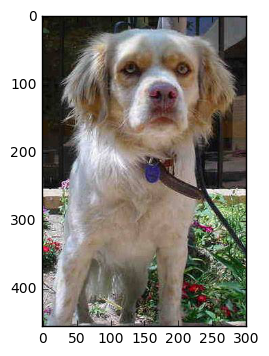

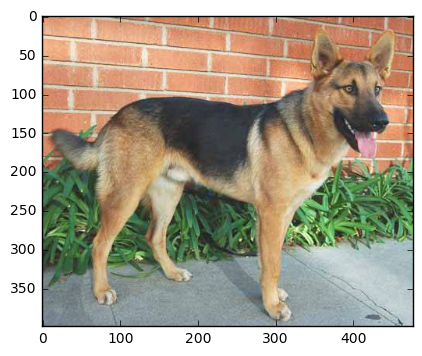

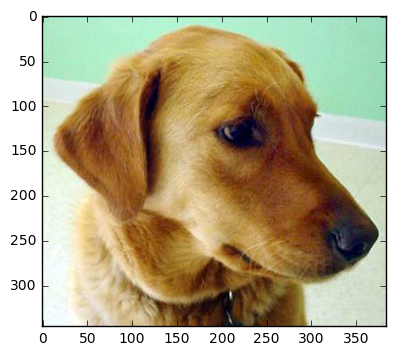

In [23]:
original = os.listdir(os.path.join(directory, 'sample'))
for ima in original:
    ima_path = os.path.join(directory, 'sample', ima)
    img = mpimg.imread(ima_path)
    plt.figure()
    plt.imshow(img)
plt.show()

C:\Users\WAWEIMIN\SciSoft\Anaconda\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


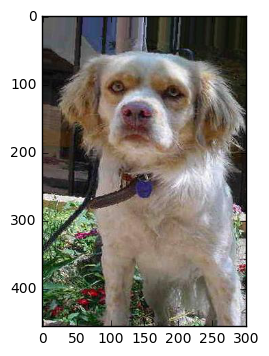

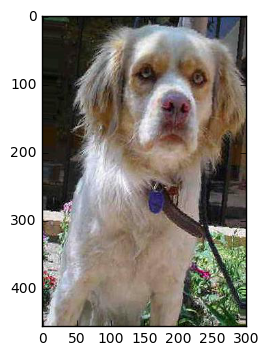

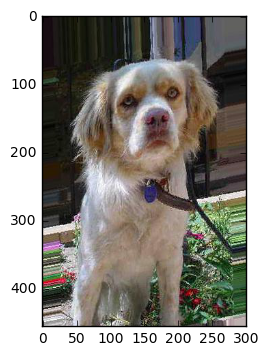

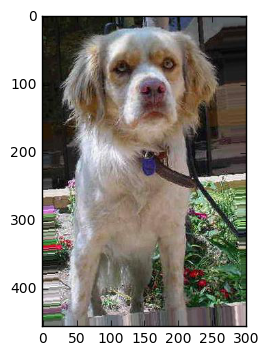

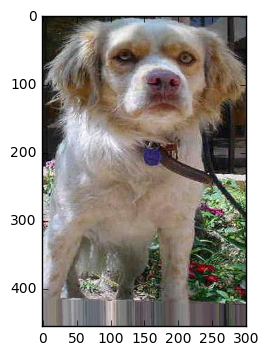

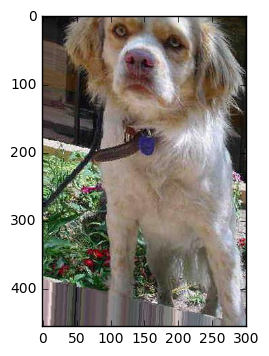

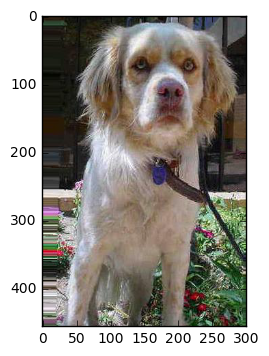

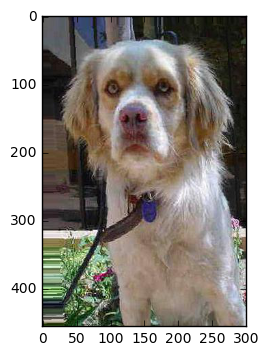

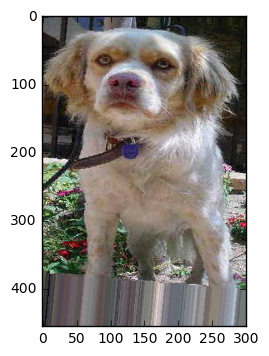

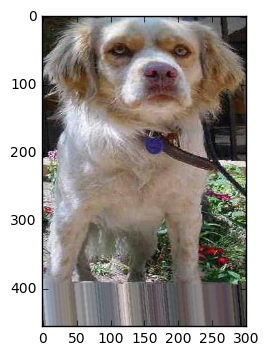

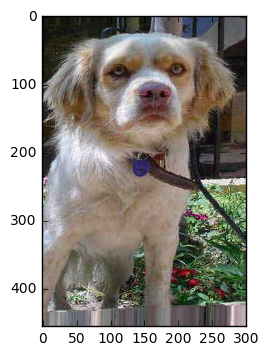

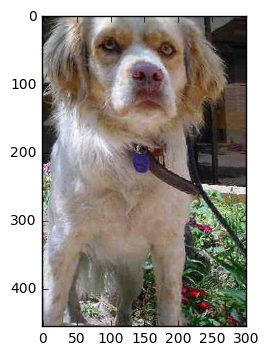

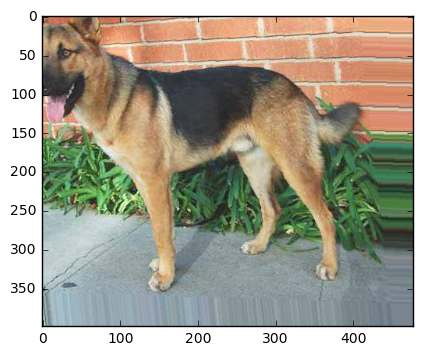

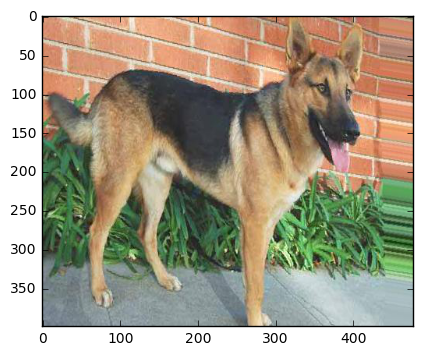

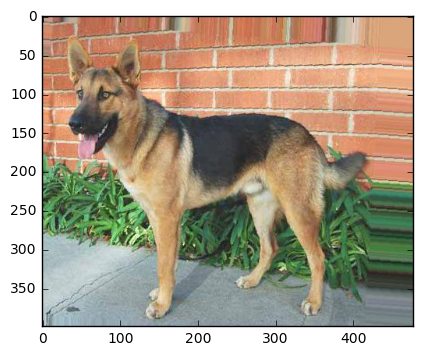

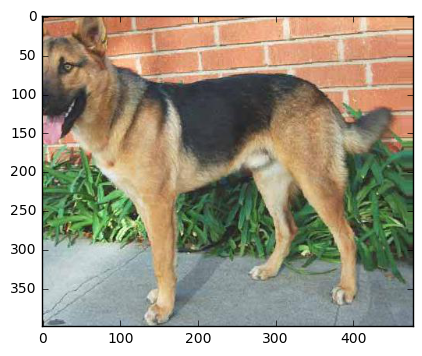

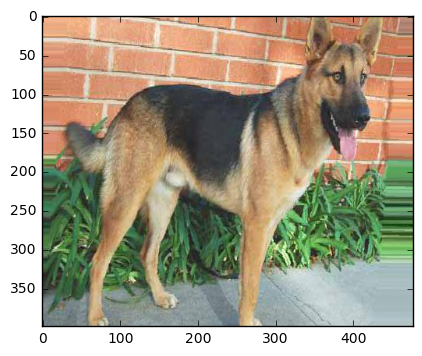

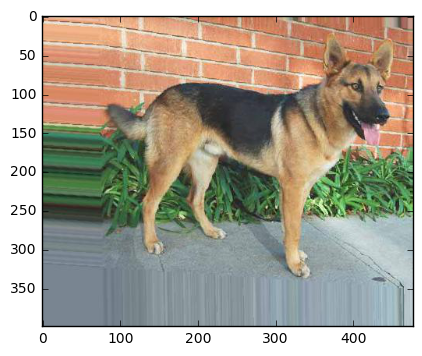

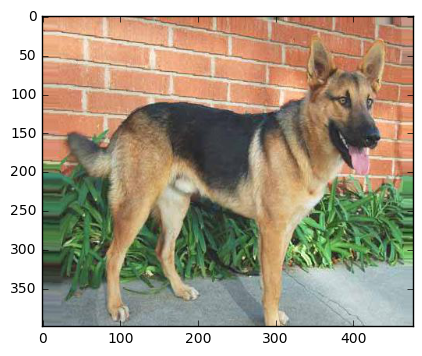

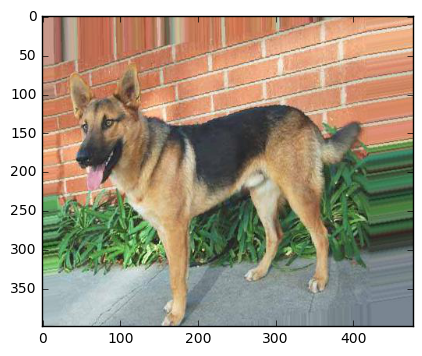

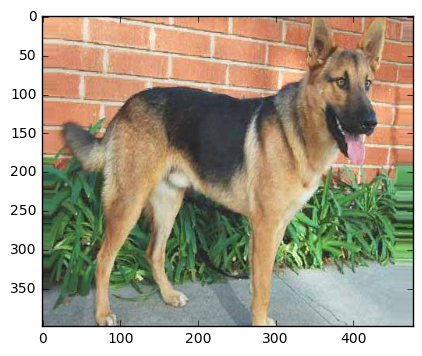

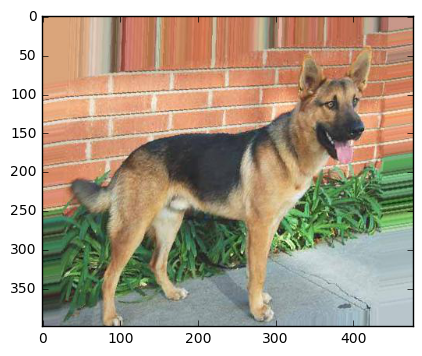

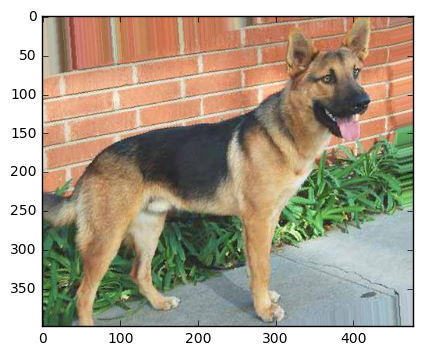

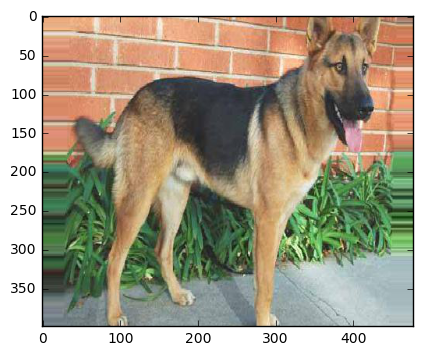

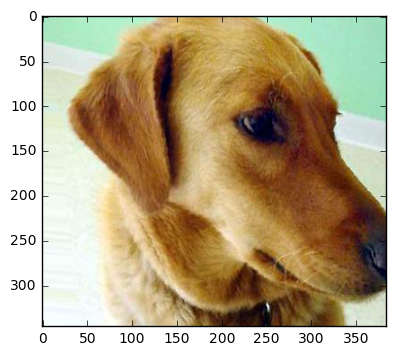

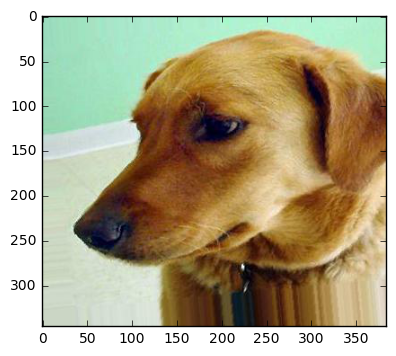

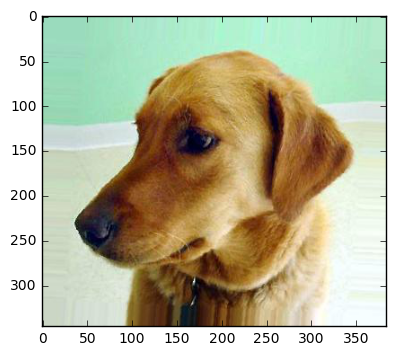

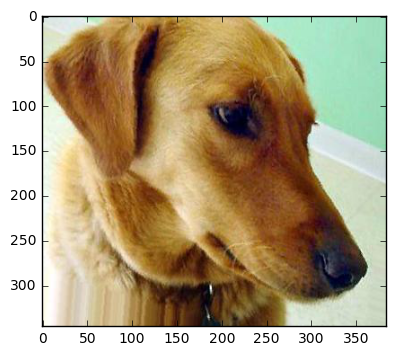

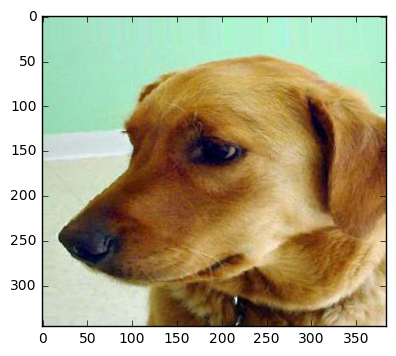

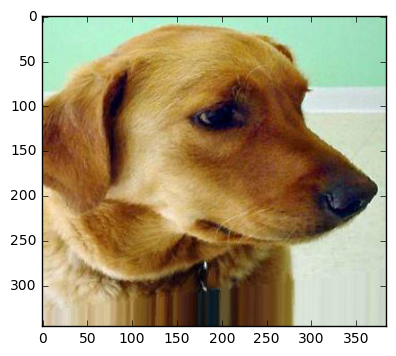

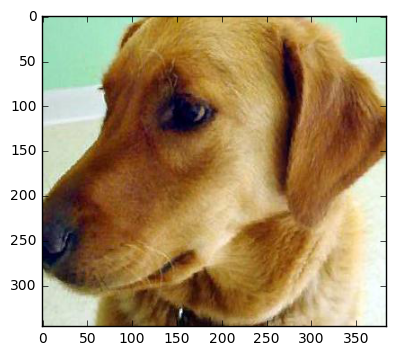

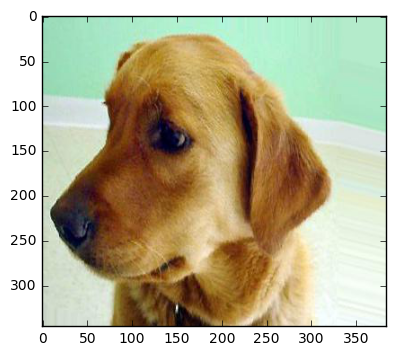

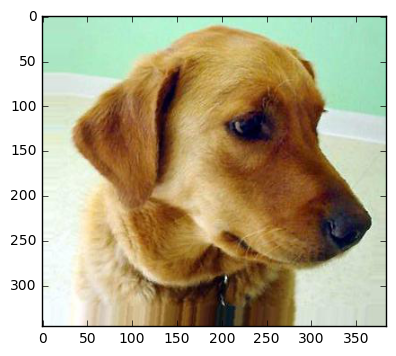

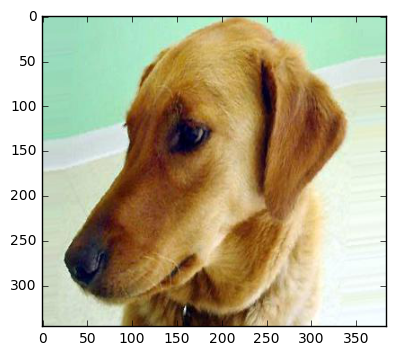

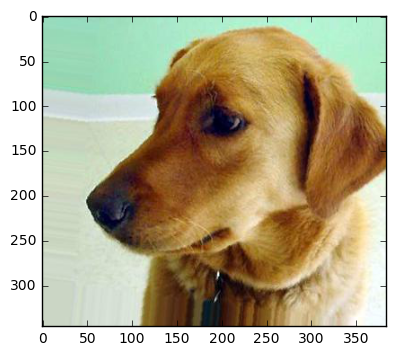

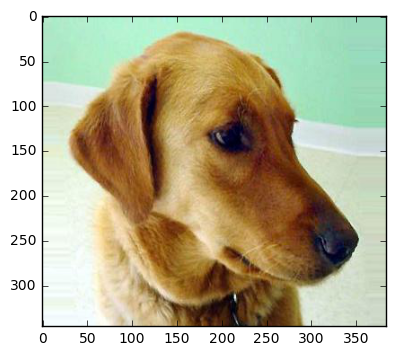

In [24]:
original = os.listdir(os.path.join(directory, 'sample_augmented'))
for ima in original:
    ima_path = os.path.join(directory, 'sample_augmented', ima)
    img = mpimg.imread(ima_path)
    plt.figure()
    plt.imshow(img)
plt.show()

## What to do next?
### 1) Try a different model (ResNet-50), or try different layers of VGG (e.g. FC1 layer) . 
### 2) Apply data augmentation on your current data set, and see how much accuracy improvement it could    bring.
### 3) Find a real-world challenge to apply on!